**Cryptocurrency Volatility Prediction- Problem Statement**

**1. Import Required Libraries**

In [28]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

**2. Load Dataset**

In [3]:
df = pd.read_csv("dataset.csv")

# Check basic info
df.head()

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,5/5/2013
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,5/5/2013
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,5/6/2013
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,5/6/2013
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,5/7/2013


**3. Data Preprocessing**

- **3.1 Convert Date & Sort**

In [4]:
# 3.1 Convert Date & Sort

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['crypto_name', 'date'])

In [5]:
# 3.2 Handle Missing Values

df.isnull().sum()

,0
Unnamed: 0,0
open,0
high,0
low,0
close,0
volume,0
marketCap,0
timestamp,0
crypto_name,0
date,0


In [6]:
# Forward fill for time-series continuity
df.fillna(method='ffill', inplace=True)

# Drop remaining nulls if any
df.dropna(inplace=True)

**4. Feature Engineering**

In [7]:
# 4.1 Volatility Target Variable
# We define volatility using log returns.

df['log_return'] = np.log(df['close'] / df['close'].shift(1))

In [8]:
# Rolling Volatility (Target)

df['volatility'] = df['log_return'].rolling(window=7).std()

In [9]:
# 4.2 Technical Indicators

# Moving Averages
df['ma_7'] = df['close'].rolling(window=7).mean()
df['ma_14'] = df['close'].rolling(window=14).mean()

In [10]:
# Bollinger Bands

df['bb_upper'] = df['ma_14'] + 2 * df['close'].rolling(14).std()
df['bb_lower'] = df['ma_14'] - 2 * df['close'].rolling(14).std()

In [11]:
# Average True Range (ATR)

df['high_low'] = df['high'] - df['low']
df['high_close'] = np.abs(df['high'] - df['close'].shift())
df['low_close'] = np.abs(df['low'] - df['close'].shift())

df['true_range'] = df[['high_low','high_close','low_close']].max(axis=1)
df['ATR'] = df['true_range'].rolling(14).mean()

In [12]:
# 4.3 Liquidity Feature

df['liquidity_ratio'] = df['volume'] / df['marketCap']

In [13]:
# 4.4 Drop NaNs After Feature Engineering

df.dropna(inplace=True)

**5. Exploratory Data Analysis (EDA)**

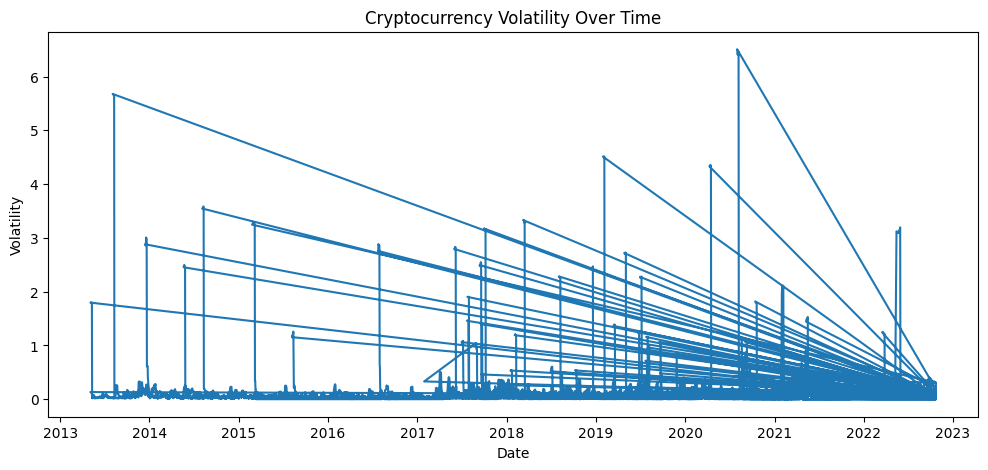

In [14]:
# 5.1 Volatility Trend

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['volatility'])
plt.title("Cryptocurrency Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

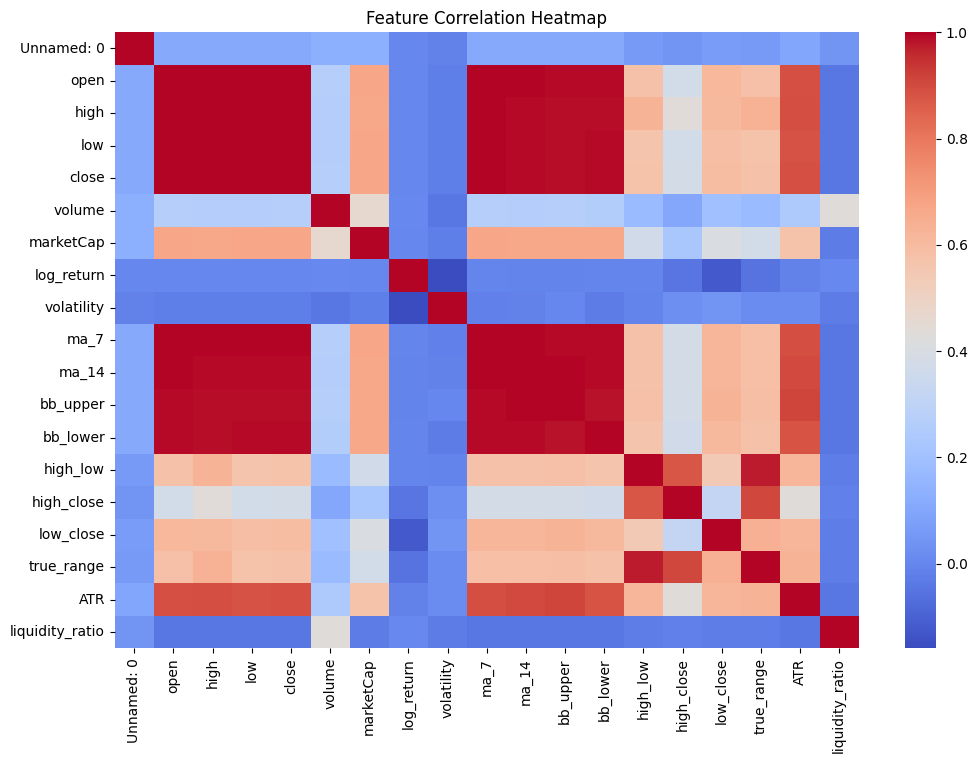

In [15]:
# 5.2 Correlation Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

**6. Prepare Data for Modeling**

In [16]:
# 6.1 Feature Selection

features = [
    'open','high','low','close','volume','marketCap',
    'ma_7','ma_14','bb_upper','bb_lower',
    'ATR','liquidity_ratio'
]

X = df[features]
y = df['volatility']

In [17]:
# 6.2 Train-Test Split (Time Series Safe)

split = int(len(df) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [18]:
# 6.3 Feature Scaling

# Replace infinite values with NaN in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values (including those from replaced inf) from X_train and y_train
nan_indices_train = X_train.index[X_train.isnull().any(axis=1)]
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

# Drop rows with NaN values from X_test and y_test
nan_indices_test = X_test.index[X_test.isnull().any(axis=1)]
X_test = X_test.drop(nan_indices_test)
y_test = y_test.drop(nan_indices_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**7. Model Training**

In [57]:
# 7.1 Linear Regression (Baseline)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_preds = lr.predict(X_test_scaled)

In [58]:
# 7.2 Random Forest Regressor (Main Model)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

In [84]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [85]:
X_train

array([[ 0.26256133, -0.81925786,  0.19358991, -0.47622087,  0.87438918],
       [ 0.69553776,  0.66874166,  0.84910211, -1.09170088, -0.3870997 ],
       [ 0.06980208,  0.46210347, -0.3853136 ,  0.1990597 , -0.60021688],
       ...,
       [-0.65000258, -0.13125697,  0.16865467,  0.07685188, -0.22485598],
       [ 0.89019841, -0.75849533,  1.03524933, -0.23040071, -0.92423314],
       [-0.62696706, -0.70317643,  1.81244856, -0.03498849,  1.77080064]])

In [86]:
X_test

array([[-5.04179831e-01,  1.19250751e+00, -8.15226731e-02,
        -1.77858758e+00,  3.19651826e-01],
       [-7.55745159e-01, -6.68090454e-01,  5.36509844e-01,
         9.92042350e-01, -1.74959757e-01],
       [-1.61271587e+00,  2.31465857e+00, -4.71931866e-01,
        -1.86726519e+00,  6.86260190e-01],
       [-1.58119070e+00, -1.58413594e+00,  8.95038314e-01,
         2.67126651e-01,  5.08725023e-01],
       [ 8.13517217e-01,  1.54993441e+00, -1.23086432e+00,
        -7.83253292e-01, -3.22061516e-01],
       [-8.87492178e-01,  6.48280434e-01, -4.37458300e-01,
        -1.20948149e-01,  4.19532444e-01],
       [ 1.18901653e+00, -6.23140526e-01,  1.42050425e+00,
        -5.55477119e-01, -6.37387127e-01],
       [-1.29683195e+00,  6.62881269e-01,  3.99687952e-01,
         1.17347386e+00,  1.81021559e-01],
       [-9.91758638e-02, -1.28030440e+00,  1.84663700e+00,
         8.72457328e-01,  6.50201178e-01],
       [ 2.80991868e-01, -1.95208780e+00, -6.22699520e-01,
        -1.51785095e-01

**8. Hyperparameter Tuning (GridSearchCV)**

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [94]:
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Prediction on unseen data
rf_preds = best_rf.predict(X_test)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


**9. Model Evaluation**

In [89]:
# 9.1 Evaluation Function

def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2 Score:", r2_score(y_true, y_pred))

In [90]:
evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest")


Linear Regression Performance
MAE: 8.40383272497967
RMSE: 10.311401479279889
R2 Score: 0.9910587469991373

Random Forest Performance
MAE: 25.414045960651702
RMSE: 31.43898679829332
R2 Score: 0.9168810452451143


**10. Prediction Visualization**

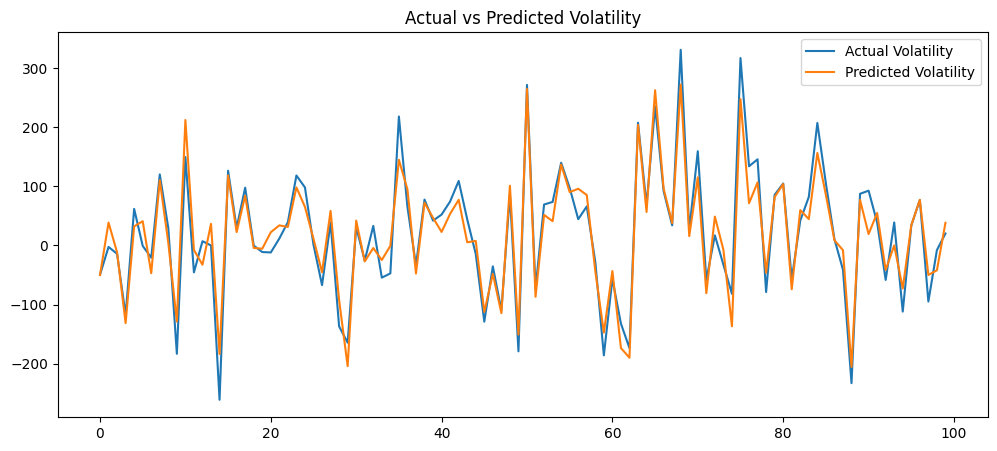

In [91]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Actual Volatility")
plt.plot(rf_preds, label="Predicted Volatility")
plt.legend()
plt.title("Actual vs Predicted Volatility")
plt.show()

**11. Feature Importance**

In [135]:
feature_names = X.columns

In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [138]:
print(len(rf.feature_importances_))
print(len(feature_names))

5
5


In [139]:
selected_features = [
    'open', 'high', 'low', 'close', 'volume'
]

In [140]:
X = df[selected_features]
y = df['volatility']

In [141]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [142]:
import pandas as pd

feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

  Feature  Importance
1    high    0.472288
3   close    0.397640
2     low    0.058234
0    open    0.052253
4  volume    0.019584


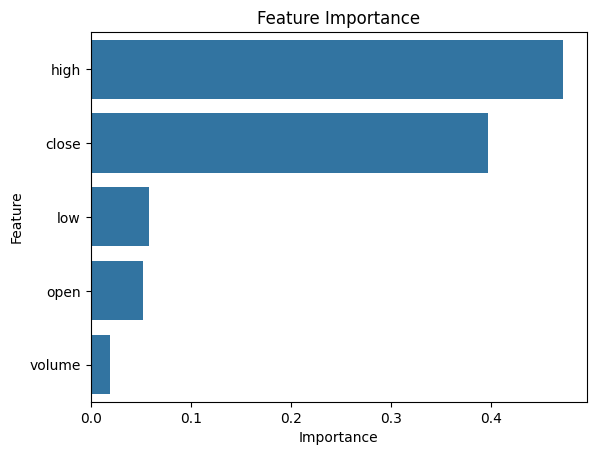

In [145]:
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title("Feature Importance")
plt.show()

**12. Save Model (For Deployment)**

In [149]:
import joblib

# Save model and scaler
joblib.dump(rf, "rf_volatility_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']